In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from loader_util.datasets import CustomTorchDataset, train_test_split_paths 
from torchvision import datasets, transforms, models

In [2]:
# define constants
batch_size = 32
num_epochs = 10

In [3]:
data_dir = r"/home/mhasan3/Desktop/WorkFolder/cellImages3/"

In [5]:
baseModel = models.vgg16(pretrained=True)

In [6]:
# remove classifier head
for param in baseModel.parameters():
    param.requires_grad = False

In [7]:
# remove head
cell_types = 3
fcHead = nn.Linear(in_features=4096, out_features=cell_types)
baseModel.classifier[6] = fcHead

In [8]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
trainPaths, testPaths = train_test_split_paths(data_dir)

In [10]:
train_data = CustomTorchDataset(pathList=trainPaths,
                                tranforms=train_transform)
test_data = CustomTorchDataset(pathList=testPaths,
                                tranforms=valid_transforms)

In [11]:
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)
test_loader = DataLoader(test_data,
                         batch_size=batch_size)

In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseModel.to(device=device)
device

device(type='cuda', index=0)

In [13]:
params_to_update = []
print("Params to learn:")

for name,param in baseModel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [14]:
epoch_train_losses = []
epoch_train_accus = []
epoch_valid_losses = []
epoch_valid_accus = []

# define the loss
criterion = nn.CrossEntropyLoss()

# create the optimizer
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# loop over the epochs
for epoch in range (1, num_epochs + 1):
    
    # keep track of all losses
    running_train_loss = 0
    running_valid_loss = 0
    
    running_train_acc = 0
    running_valid_acc = 0
    
    train_batch_no = 0
    valid_batch_no = 0
    
    # TRAIN
    baseModel.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train_batch_no += 1
        
        # Training pass
        optimizer.zero_grad()
        logits = baseModel(images)
        loss = criterion(logits, labels)
        
        # exponentiate the logits
        exp_logits = torch.exp(logits)
        
        # pass thru softmax to calculate probs
        probs = exp_logits / (torch.sum(exp_logits, dim=1).view(exp_logits.shape[0],-1))
        
        # get top class and to class prob
        top_p, top_class = probs.topk(1, dim=1)
        
        # reshape labels into column vector
        labels = labels.view(labels.shape[0], -1)
    
        # find which labels are correctly classified
        acc_boolean = top_class == labels
       
        # finally calculate accuracy
        running_train_acc += np.sum(acc_boolean.cpu().numpy()) / len(acc_boolean)
        
        # make gradient descent step
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    else:
        epoch_train_loss = running_train_loss / train_batch_no
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_accu = running_train_acc / train_batch_no
        epoch_train_accus.append(epoch_train_accu)
        print(f"Epoch: {epoch}")
        print(f'{train_batch_no} train batches completed')
        
        
    
    # VALIDATE
    baseModel.eval()
    with torch.no_grad():
        for valid_images, valid_labels in test_loader:
            valid_images, valid_labels = valid_images.to(device), valid_labels.to\
                (device)
            valid_batch_no += 1
            
            # Validation pass
            valid_logits = baseModel(valid_images)
            valid_loss = criterion(valid_logits, valid_labels)
            
            # exponentiate the logits
            valid_exp_logits = torch.exp(valid_logits)
            
            # pass thru softmax to calculate probs
            valid_probs = valid_exp_logits / (torch.sum(valid_exp_logits, dim=1)
                                              .view(valid_exp_logits.shape[0],-1))
            
            # get top class and to class prob
            valid_top_p, valid_top_class = valid_probs.topk(1, dim=1)
            
            # reshape labels into column vector
            valid_labels = valid_labels.view(valid_labels.shape[0], -1)
        
            # find which labels are correctly classified
            valid_acc_boolean = valid_top_class == valid_labels
           
            # finally calculate accuracy
            running_valid_acc += np.sum(valid_acc_boolean.cpu().numpy()) / len\
                (valid_acc_boolean)
    
            running_valid_loss += valid_loss.item()
        else:
            # dividing because running loss is the sum loss of all batches 
            epoch_valid_loss = running_valid_loss / valid_batch_no
            epoch_valid_accu = running_valid_acc / valid_batch_no
            epoch_valid_losses.append(epoch_valid_loss)
            epoch_valid_accus.append(epoch_valid_accu)
            print ( f"Training loss: {epoch_train_loss} " )
            print(f'Train accu: {epoch_train_accu}')
            print(f'{valid_batch_no} test batches completed')
            print ( f"Validation loss: {epoch_valid_loss}")
            print(f'Validation accu: {epoch_valid_accu}')
            print("=" * 50)

Epoch: 1
38 train batches completed
Training loss: 0.5803627183562831 
Train accu: 0.7594888663967612
17 test batches completed
Validation loss: 0.2512383198036867
Validation accu: 0.9319852941176471
Epoch: 2
38 train batches completed
Training loss: 0.24833209989102265 
Train accu: 0.9262398785425102
17 test batches completed
Validation loss: 0.18606916245292215
Validation accu: 0.9491421568627452
Epoch: 3
38 train batches completed
Training loss: 0.19950045743270925 
Train accu: 0.9305414979757084
17 test batches completed
Validation loss: 0.12992741824949489
Validation accu: 0.9736519607843137
Epoch: 4
38 train batches completed
Training loss: 0.15757418816026889 
Train accu: 0.9496457489878543
17 test batches completed
Validation loss: 0.11506309009650174
Validation accu: 0.9816176470588235
Epoch: 5
38 train batches completed
Training loss: 0.1652799595735575 
Train accu: 0.9463562753036436
17 test batches completed
Validation loss: 0.09723128729006823
Validation accu: 0.9834558823

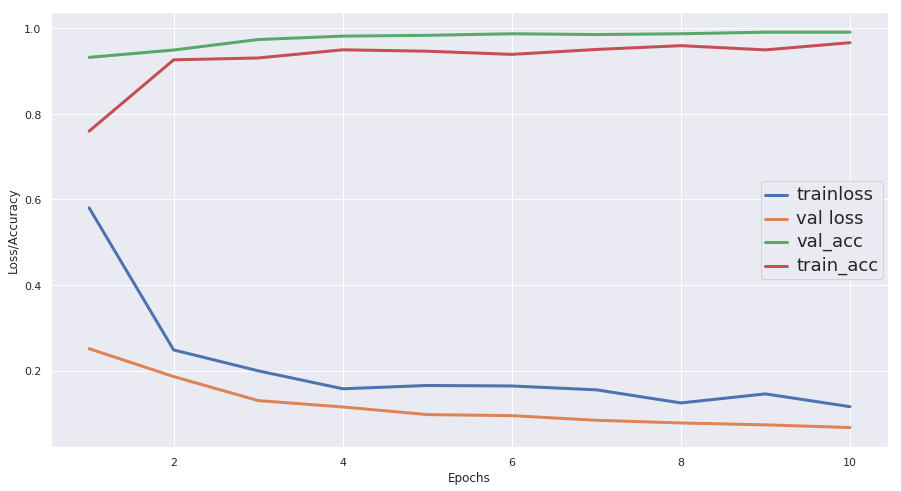

In [18]:
# evaluate the network
# plot the performance
import pandas as pd
epochs = range(1, num_epochs+1)
plot_df = pd.DataFrame(data=np.c_[epochs, epoch_train_losses, 
                                  epoch_valid_losses, epoch_train_accus, 
                                  epoch_valid_accus], 
                       columns=['epochs','train_loss', 'test_loss', 
                                'train_acc', 'valid_acc'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='train_loss', ax=ax, label='trainloss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='test_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='valid_acc', ax=ax, label='val_acc', 
             linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='train_acc', ax=ax, 
             label='train_acc', linewidth=3)
ax.set_ylabel('Loss/Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text         

#### INFERENCE

In [21]:
for param_tensor in baseModel.state_dict():
    print(param_tensor, "\t", baseModel.state_dict()[param_tensor].size())

features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.2.weight 	 torch.Size([64, 64, 3, 3])
features.2.bias 	 torch.Size([64])
features.5.weight 	 torch.Size([128, 64, 3, 3])
features.5.bias 	 torch.Size([128])
features.7.weight 	 torch.Size([128, 128, 3, 3])
features.7.bias 	 torch.Size([128])
features.10.weight 	 torch.Size([256, 128, 3, 3])
features.10.bias 	 torch.Size([256])
features.12.weight 	 torch.Size([256, 256, 3, 3])
features.12.bias 	 torch.Size([256])
features.14.weight 	 torch.Size([256, 256, 3, 3])
features.14.bias 	 torch.Size([256])
features.17.weight 	 torch.Size([512, 256, 3, 3])
features.17.bias 	 torch.Size([512])
features.19.weight 	 torch.Size([512, 512, 3, 3])
features.19.bias 	 torch.Size([512])
features.21.weight 	 torch.Size([512, 512, 3, 3])
features.21.bias 	 torch.Size([512])
features.24.weight 	 torch.Size([512, 512, 3, 3])
features.24.bias 	 torch.Size([512])
features.26.weight 	 torch.Size([512, 512, 3, 3])
features.

In [22]:
torch.save(baseModel, 'torch_checkpoint.pth')

In [23]:
model = torch.load('torch_checkpoint.pth')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

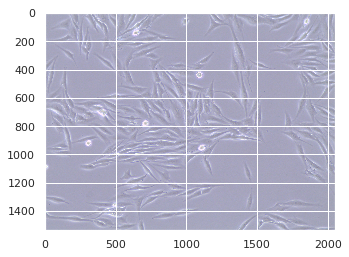

In [60]:
import cv2
image_name = 'MG63Sample.jpg'
cv_img = cv2.imread(image_name)
plt.imshow(cv_img[:,:,::-1])

In [61]:
pil_img = Image.open(image_name)

In [62]:
transformed_pil_image = valid_transforms(pil_img)

In [63]:
transformed_pil_image.shape

torch.Size([3, 224, 224])

In [64]:
transformed_pil_image = torch.unsqueeze(transformed_pil_image, 0)
transformed_pil_image.shape

torch.Size([1, 3, 224, 224])

In [65]:
logits_for_image = model(transformed_pil_image.to(device))

In [66]:
exp_logits = torch.exp(logits_for_image)

In [68]:
probs = exp_logits / torch.sum(exp_logits)
probs

tensor([[0.0190, 0.9461, 0.0349]], device='cuda:0', grad_fn=<DivBackward0>)

In [70]:
train_data.classes

['3T3', 'MG 63', 'hASC']

In [73]:
i = Image.fromarray(cv_img[:,:,::-1])

In [76]:
images, labels = next(iter(train_loader))

In [81]:
labels

tensor([1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1,
        0, 1, 0, 1, 0, 1, 2, 2])

In [79]:
logits.shape

torch.Size([26, 3])

In [80]:
logits

tensor([[-1.8914,  7.5750, -5.3011],
        [ 5.4385, -3.2570, -0.6659],
        [ 1.2752,  0.5711, -0.9105],
        [ 6.6092, -6.2900, -0.0878],
        [-2.5466, -1.8143,  5.3818],
        [ 1.7899,  0.2572, -0.3865],
        [-3.2868,  4.3097,  0.4166],
        [-0.9126, -2.3758,  4.1821],
        [ 3.8536,  1.2011, -5.0742],
        [ 0.2230, -0.2121,  0.8679],
        [-3.3824,  4.4999, -0.8116],
        [-2.2185,  5.9556, -2.8751],
        [ 7.0162, -3.9754, -1.2962],
        [ 1.5502, -3.7786,  4.7419],
        [-2.2954,  5.7908, -2.1796],
        [ 0.7693, -3.8956,  4.1996],
        [-2.8996,  4.0057,  0.1376],
        [-1.3264, -3.0859,  5.1487],
        [-4.5353,  7.1030, -1.6384],
        [-5.1833,  6.9409, -0.5283],
        [ 0.1030,  1.4329, -0.5263],
        [-2.4154,  3.6768, -0.0535],
        [-2.2884,  0.8680,  3.1371],
        [-3.7038,  3.7687,  1.4060],
        [-1.3101, -0.7491,  3.7322],
        [-1.2056, -1.2335,  3.9021]], device='cuda:0', grad_fn=<AddmmBackwa